In [9]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

pd.set_option('display.max_colwidth', None)

from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mutual_info_score
import category_encoders as ce

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import KFold
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBClassifier

In [10]:
matches_df = pd.read_csv('DATA/matches.csv')
matches_df.head()

,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
1,335983,2007/08,Chandigarh,2008-04-19,League,MEK Hussey,"Punjab Cricket Association Stadium, Mohali",Kings XI Punjab,Chennai Super Kings,Chennai Super Kings,bat,Chennai Super Kings,runs,33.0,241.0,20.0,N,NaN,MR Benson,SL Shastri
2,335984,2007/08,Delhi,2008-04-19,League,MF Maharoof,Feroz Shah Kotla,Delhi Daredevils,Rajasthan Royals,Rajasthan Royals,bat,Delhi Daredevils,wickets,9.0,130.0,20.0,N,NaN,Aleem Dar,GA Pratapkumar
3,335985,2007/08,Mumbai,2008-04-20,League,MV Boucher,Wankhede Stadium,Mumbai Indians,Royal Challengers Bangalore,Mumbai Indians,bat,Royal Challengers Bangalore,wickets,5.0,166.0,20.0,N,NaN,SJ Davis,DJ Harper
4,335986,2007/08,Kolkata,2008-04-20,League,DJ Hussey,Eden Gardens,Kolkata Knight Riders,Deccan Chargers,Deccan Chargers,bat,Kolkata Knight Riders,wickets,5.0,111.0,20.0,N,NaN,BF Bowden,K Hariharan


In [11]:
deliveries_df = pd.read_csv('DATA/deliveries.csv')
deliveries_df.head()

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
0,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,1,SC Ganguly,P Kumar,BB McCullum,0,1,1,legbyes,0,NaN,NaN,NaN
1,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,2,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
2,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,3,BB McCullum,P Kumar,SC Ganguly,0,1,1,wides,0,NaN,NaN,NaN
3,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,4,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN
4,335982,1,Kolkata Knight Riders,Royal Challengers Bangalore,0,5,BB McCullum,P Kumar,SC Ganguly,0,0,0,NaN,0,NaN,NaN,NaN


In [12]:
# Filter the deliveries for 2nd innings only.

second_innings = deliveries_df[deliveries_df.inning == 2]
second_innings.head()

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder
124,335982,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,1,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN
125,335982,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,2,W Jaffer,AB Dinda,R Dravid,0,1,1,wides,0,NaN,NaN,NaN
126,335982,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,3,W Jaffer,AB Dinda,R Dravid,0,0,0,NaN,0,NaN,NaN,NaN
127,335982,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,4,W Jaffer,AB Dinda,R Dravid,1,0,1,NaN,0,NaN,NaN,NaN
128,335982,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,5,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN


In [13]:
len(second_innings)

125741

In [14]:
gdf = second_innings.sort_values(['match_id', 'over', 'ball']).reset_index(drop=True)

# Rolling sums via .apply()
gdf['runs_last_12_balls'] = (
    gdf.groupby('match_id', group_keys=False)['total_runs']
       .apply(lambda x: x.shift(1).rolling(window=12, min_periods=1).sum())
)

gdf['wickets_last_12_balls'] = (
    gdf.groupby('match_id', group_keys=False)['is_wicket']
       .apply(lambda x: x.shift(1).rolling(window=12, min_periods=1).sum())
)


In [15]:
gdf.head()

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,runs_last_12_balls,wickets_last_12_balls
0,335982,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,1,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN,NaN,NaN
1,335982,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,2,W Jaffer,AB Dinda,R Dravid,0,1,1,wides,0,NaN,NaN,NaN,1.0,0.0
2,335982,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,3,W Jaffer,AB Dinda,R Dravid,0,0,0,NaN,0,NaN,NaN,NaN,2.0,0.0
3,335982,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,4,W Jaffer,AB Dinda,R Dravid,1,0,1,NaN,0,NaN,NaN,NaN,2.0,0.0
4,335982,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,5,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN,3.0,0.0


In [16]:
# Merge with matches 

merged_df = gdf.merge(
    matches_df,
    how='left',
    left_on='match_id',
    right_on='id'
)
merged_df.head()

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,runs_last_12_balls,wickets_last_12_balls,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2
0,335982,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,1,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN,NaN,NaN,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
1,335982,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,2,W Jaffer,AB Dinda,R Dravid,0,1,1,wides,0,NaN,NaN,NaN,1.0,0.0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
2,335982,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,3,W Jaffer,AB Dinda,R Dravid,0,0,0,NaN,0,NaN,NaN,NaN,2.0,0.0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
3,335982,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,4,W Jaffer,AB Dinda,R Dravid,1,0,1,NaN,0,NaN,NaN,NaN,2.0,0.0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen
4,335982,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,5,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN,3.0,0.0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen


In [17]:
# Compute current score

merged_df['current_score'] = merged_df.groupby('match_id')['total_runs'].cumsum()
merged_df['wickets_down'] = merged_df.groupby('match_id')['is_wicket'].cumsum()
merged_df['balls_remaining'] = (merged_df.target_overs * 6) - (merged_df.over * 6 + merged_df.ball)
merged_df['required_run_rate'] = (merged_df.target_runs - merged_df.current_score) * 6 / merged_df.balls_remaining
merged_df.head(10)

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,runs_last_12_balls,wickets_last_12_balls,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2,current_score,wickets_down,balls_remaining,required_run_rate
0,335982,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,1,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN,NaN,NaN,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen,1,0,119.0,11.193277
1,335982,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,2,W Jaffer,AB Dinda,R Dravid,0,1,1,wides,0,NaN,NaN,NaN,1.0,0.0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen,2,0,118.0,11.237288
2,335982,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,3,W Jaffer,AB Dinda,R Dravid,0,0,0,NaN,0,NaN,NaN,NaN,2.0,0.0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen,2,0,117.0,11.333333
3,335982,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,4,W Jaffer,AB Dinda,R Dravid,1,0,1,NaN,0,NaN,NaN,NaN,2.0,0.0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen,3,0,116.0,11.379310
4,335982,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,5,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN,3.0,0.0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen,4,0,115.0,11.426087
5,335982,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,6,W Jaffer,AB Dinda,R Dravid,0,0,0,NaN,0,NaN,NaN,NaN,4.0,0.0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen,4,0,114.0,11.526316
6,335982,2,Royal Challengers Bangalore,Kolkata Knight Riders,0,7,W Jaffer,AB Dinda,R Dravid,0,0,0,NaN,0,NaN,NaN,NaN,4.0,0.0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen,4,0,113.0,11.628319
7,335982,2,Royal Challengers Bangalore,Kolkata Knight Riders,1,1,R Dravid,I Sharma,W Jaffer,0,0,0,NaN,1,R Dravid,bowled,NaN,4.0,0.0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen,4,1,113.0,11.628319
8,335982,2,Royal Challengers Bangalore,Kolkata Knight Riders,1,2,V Kohli,I Sharma,W Jaffer,0,0,0,NaN,0,NaN,NaN,NaN,4.0,1.0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,Royal Challengers Bangalore,Kolkata Knight Riders,Royal Challengers Bangalore,field,Kolkata Knight Riders,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen,4,1,112.0,11.732143
9,335982,2,Royal Challengers Bangalore,Kolkata Knight Riders,1,3,V Kohli,I Sharma,W Jaffer,0,4,4,legbyes,0,NaN,NaN,NaN,4.0,1.0,335982,2007/08,

In [18]:
# EDA

In [19]:
merged_df.batting_team.value_counts()

batting_team
Kolkata Knight Riders          14772
Mumbai Indians                 14734
Rajasthan Royals               13498
Royal Challengers Bangalore    13426
Chennai Super Kings            12561
Kings XI Punjab                10753
Sunrisers Hyderabad            10178
Delhi Daredevils               10027
Delhi Capitals                  5826
Deccan Chargers                 3754
Pune Warriors                   2995
Punjab Kings                    2951
Gujarat Titans                  2880
Lucknow Super Giants            2526
Gujarat Lions                   1832
Rising Pune Supergiant           906
Rising Pune Supergiants          731
Kochi Tuskers Kerala             706
Royal Challengers Bengaluru      685
Name: count, dtype: int64

In [20]:
team_map = {
    "Kolkata Knight Riders": "KKR",
    "Mumbai Indians": "MI",
    "Rajasthan Royals": "RR",
    "Royal Challengers Bangalore": "RCB",
    "Royal Challengers Bengaluru": "RCB",
    "Chennai Super Kings": "CSK",
    "Kings XI Punjab": "PK",
    "Punjab Kings": "PK",
    "Sunrisers Hyderabad": "SRH",
    "Deccan Chargers": "SRH",
    "Delhi Daredevils": "DCA",
    "Delhi Capitals": "DCA",
    "Pune Warriors": "SG",
    "Rising Pune Supergiant": "SG",
    "Rising Pune Supergiants": "SG",
    "Lucknow Super Giants": "SG",
    "Gujarat Titans": "GT",
    "Gujarat Lions": "GT",
    "Kochi Tuskers Kerala": "KTK"
}

In [21]:
for col in ['batting_team', 'bowling_team', 'team1', 'team2', 'toss_winner', 'winner']:
    merged_df[col] = merged_df[col].replace(team_map)

# Check for missing data. 
for col in ['batting_team', 'bowling_team', 'team1', 'team2', 'toss_winner', 'winner']:
    print(merged_df[col].value_counts())
    print()

batting_team
DCA    15853
KKR    14772
MI     14734
RCB    14111
SRH    13932
PK     13704
RR     13498
CSK    12561
SG      7158
GT      4712
KTK      706
Name: count, dtype: int64

bowling_team
SRH    15868
MI     15730
CSK    15230
RCB    14873
PK     14619
KKR    13502
DCA    12753
RR     11852
SG      6630
GT      3910
KTK      774
Name: count, dtype: int64

team1
RCB    16232
CSK    15248
SRH    14429
MI     14366
DCA    14336
PK     14153
KKR    13638
RR     11635
SG      6846
GT      4140
KTK      718
Name: count, dtype: int64

team2
MI     16098
SRH    15371
KKR    14636
DCA    14270
PK     14170
RR     13715
RCB    12752
CSK    12543
SG      6942
GT      4482
KTK      762
Name: count, dtype: int64

toss_winner
MI     16574
SRH    14999
DCA    14747
CSK    14228
RR     13855
KKR    13833
RCB    13744
PK     12683
SG      5939
GT      4348
KTK      791
Name: count, dtype: int64

winner
MI     16729
CSK    16295
KKR    14657
RCB    13968
SRH    13489
DCA    13140
RR     13112
PK

In [22]:
merged_df.head()

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,runs_last_12_balls,wickets_last_12_balls,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2,current_score,wickets_down,balls_remaining,required_run_rate
0,335982,2,RCB,KKR,0,1,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN,NaN,NaN,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,RCB,KKR,RCB,field,KKR,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen,1,0,119.0,11.193277
1,335982,2,RCB,KKR,0,2,W Jaffer,AB Dinda,R Dravid,0,1,1,wides,0,NaN,NaN,NaN,1.0,0.0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,RCB,KKR,RCB,field,KKR,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen,2,0,118.0,11.237288
2,335982,2,RCB,KKR,0,3,W Jaffer,AB Dinda,R Dravid,0,0,0,NaN,0,NaN,NaN,NaN,2.0,0.0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,RCB,KKR,RCB,field,KKR,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen,2,0,117.0,11.333333
3,335982,2,RCB,KKR,0,4,W Jaffer,AB Dinda,R Dravid,1,0,1,NaN,0,NaN,NaN,NaN,2.0,0.0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,RCB,KKR,RCB,field,KKR,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen,3,0,116.0,11.379310
4,335982,2,RCB,KKR,0,5,R Dravid,AB Dinda,W Jaffer,1,0,1,NaN,0,NaN,NaN,NaN,3.0,0.0,335982,2007/08,Bangalore,2008-04-18,League,BB McCullum,M Chinnaswamy Stadium,RCB,KKR,RCB,field,KKR,runs,140.0,223.0,20.0,N,NaN,Asad Rauf,RE Koertzen,4,0,115.0,11.426087


In [23]:
merged_df.venue.value_counts()

venue
Eden Gardens                                                             8607
Wankhede Stadium                                                         8544
M Chinnaswamy Stadium                                                    7026
Feroz Shah Kotla                                                         6625
MA Chidambaram Stadium, Chepauk                                          5779
Rajiv Gandhi International Stadium, Uppal                                5571
Dubai International Cricket Stadium                                      5458
Sawai Mansingh Stadium                                                   5318
Wankhede Stadium, Mumbai                                                 5261
Punjab Cricket Association Stadium, Mohali                               4019
Sheikh Zayed Stadium                                                     3336
MA Chidambaram Stadium, Chepauk, Chennai                                 3318
Sharjah Cricket Stadium                                   

In [24]:
merged_df.city.value_counts()

city
Mumbai            20231
Kolkata           10466
Delhi             10198
Chennai           10131
Hyderabad          8843
Chandigarh         7027
Bangalore          7026
Jaipur             6447
Pune               5939
Abu Dhabi          4215
Ahmedabad          4092
Bengaluru          3396
Durban             1785
Visakhapatnam      1668
Lucknow            1545
Dubai              1526
Dharamsala         1523
Centurion          1380
Rajkot             1139
Sharjah            1110
Navi Mumbai        1055
Johannesburg        945
Indore              883
Cuttack             839
Ranchi              834
Port Elizabeth      807
Cape Town           715
Raipur              689
Mohali              613
Kochi               552
Kanpur              429
Nagpur              372
Guwahati            367
Kimberley           358
East London         335
Bloemfontein        249
Name: count, dtype: int64

In [25]:
cat_cols = [col for col in merged_df.columns if merged_df[col].dtype == object]
for col in cat_cols:
    merged_df[col] = merged_df[col].str.strip().str.replace(r'\s+|\.|\,', '_', regex=True).str.lower()

In [26]:
merged_df.head()

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,runs_last_12_balls,wickets_last_12_balls,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2,current_score,wickets_down,balls_remaining,required_run_rate
0,335982,2,rcb,kkr,0,1,r_dravid,ab_dinda,w_jaffer,1,0,1,NaN,0,NaN,NaN,NaN,NaN,NaN,335982,2007/08,bangalore,2008-04-18,league,bb_mccullum,m_chinnaswamy_stadium,rcb,kkr,rcb,field,kkr,runs,140.0,223.0,20.0,n,NaN,asad_rauf,re_koertzen,1,0,119.0,11.193277
1,335982,2,rcb,kkr,0,2,w_jaffer,ab_dinda,r_dravid,0,1,1,wides,0,NaN,NaN,NaN,1.0,0.0,335982,2007/08,bangalore,2008-04-18,league,bb_mccullum,m_chinnaswamy_stadium,rcb,kkr,rcb,field,kkr,runs,140.0,223.0,20.0,n,NaN,asad_rauf,re_koertzen,2,0,118.0,11.237288
2,335982,2,rcb,kkr,0,3,w_jaffer,ab_dinda,r_dravid,0,0,0,NaN,0,NaN,NaN,NaN,2.0,0.0,335982,2007/08,bangalore,2008-04-18,league,bb_mccullum,m_chinnaswamy_stadium,rcb,kkr,rcb,field,kkr,runs,140.0,223.0,20.0,n,NaN,asad_rauf,re_koertzen,2,0,117.0,11.333333
3,335982,2,rcb,kkr,0,4,w_jaffer,ab_dinda,r_dravid,1,0,1,NaN,0,NaN,NaN,NaN,2.0,0.0,335982,2007/08,bangalore,2008-04-18,league,bb_mccullum,m_chinnaswamy_stadium,rcb,kkr,rcb,field,kkr,runs,140.0,223.0,20.0,n,NaN,asad_rauf,re_koertzen,3,0,116.0,11.379310
4,335982,2,rcb,kkr,0,5,r_dravid,ab_dinda,w_jaffer,1,0,1,NaN,0,NaN,NaN,NaN,3.0,0.0,335982,2007/08,bangalore,2008-04-18,league,bb_mccullum,m_chinnaswamy_stadium,rcb,kkr,rcb,field,kkr,runs,140.0,223.0,20.0,n,NaN,asad_rauf,re_koertzen,4,0,115.0,11.426087


In [27]:
# Output Y: Since the considered data set is of the 2nd innings, the batting team is the chasing team 
merged_df['chase'] = (merged_df['winner'] == merged_df['batting_team']).astype(int)

In [28]:
merged_df.head()

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,runs_last_12_balls,wickets_last_12_balls,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2,current_score,wickets_down,balls_remaining,required_run_rate,chase
0,335982,2,rcb,kkr,0,1,r_dravid,ab_dinda,w_jaffer,1,0,1,NaN,0,NaN,NaN,NaN,NaN,NaN,335982,2007/08,bangalore,2008-04-18,league,bb_mccullum,m_chinnaswamy_stadium,rcb,kkr,rcb,field,kkr,runs,140.0,223.0,20.0,n,NaN,asad_rauf,re_koertzen,1,0,119.0,11.193277,0
1,335982,2,rcb,kkr,0,2,w_jaffer,ab_dinda,r_dravid,0,1,1,wides,0,NaN,NaN,NaN,1.0,0.0,335982,2007/08,bangalore,2008-04-18,league,bb_mccullum,m_chinnaswamy_stadium,rcb,kkr,rcb,field,kkr,runs,140.0,223.0,20.0,n,NaN,asad_rauf,re_koertzen,2,0,118.0,11.237288,0
2,335982,2,rcb,kkr,0,3,w_jaffer,ab_dinda,r_dravid,0,0,0,NaN,0,NaN,NaN,NaN,2.0,0.0,335982,2007/08,bangalore,2008-04-18,league,bb_mccullum,m_chinnaswamy_stadium,rcb,kkr,rcb,field,kkr,runs,140.0,223.0,20.0,n,NaN,asad_rauf,re_koertzen,2,0,117.0,11.333333,0
3,335982,2,rcb,kkr,0,4,w_jaffer,ab_dinda,r_dravid,1,0,1,NaN,0,NaN,NaN,NaN,2.0,0.0,335982,2007/08,bangalore,2008-04-18,league,bb_mccullum,m_chinnaswamy_stadium,rcb,kkr,rcb,field,kkr,runs,140.0,223.0,20.0,n,NaN,asad_rauf,re_koertzen,3,0,116.0,11.379310,0
4,335982,2,rcb,kkr,0,5,r_dravid,ab_dinda,w_jaffer,1,0,1,NaN,0,NaN,NaN,NaN,3.0,0.0,335982,2007/08,bangalore,2008-04-18,league,bb_mccullum,m_chinnaswamy_stadium,rcb,kkr,rcb,field,kkr,runs,140.0,223.0,20.0,n,NaN,asad_rauf,re_koertzen,4,0,115.0,11.426087,0


In [29]:
low_cardinal_features = ['season', 'match_type', 'batting_team', 'toss_winner']
high_cardinal_features = ['city']
numeric_features = ['target_runs', 'current_score', 'wickets_down', 'balls_remaining', 'required_run_rate', 'runs_last_12_balls', 'wickets_last_12_balls' ]

cols_of_interest = low_cardinal_features + high_cardinal_features + numeric_features + ['chase']


In [30]:
cols_of_interest

['season',
 'match_type',
 'batting_team',
 'toss_winner',
 'city',
 'target_runs',
 'current_score',
 'wickets_down',
 'balls_remaining',
 'required_run_rate',
 'runs_last_12_balls',
 'wickets_last_12_balls',
 'chase']

In [31]:
merged_df[cols_of_interest].isnull().sum()

season                      0
match_type                  0
batting_team                0
toss_winner                 0
city                     6012
target_runs                 0
current_score               0
wickets_down                0
balls_remaining             0
required_run_rate          17
runs_last_12_balls       1092
wickets_last_12_balls    1092
chase                       0
dtype: int64

In [32]:
merged_df['city'] = merged_df['city'].fillna('')

In [33]:
(
    (merged_df[cols_of_interest].balls_remaining == 0).sum(),
    (merged_df[cols_of_interest].wickets_down == 10).sum()
)

(451, 117)

In [34]:
# Remove the match already won delivery rows from the dataset. 
print(len(merged_df))
merged_df = merged_df.drop(merged_df[merged_df.wickets_down == 10].index)
merged_df = merged_df.drop(merged_df[merged_df.balls_remaining == 0].index)
merged_df.reset_index(drop=True, inplace=True)
print(len(merged_df))


125741
125181


In [35]:
## EDA

In [36]:
merged_df.head()

,match_id,inning,batting_team,bowling_team,over,ball,batter,bowler,non_striker,batsman_runs,extra_runs,total_runs,extras_type,is_wicket,player_dismissed,dismissal_kind,fielder,runs_last_12_balls,wickets_last_12_balls,id,season,city,date,match_type,player_of_match,venue,team1,team2,toss_winner,toss_decision,winner,result,result_margin,target_runs,target_overs,super_over,method,umpire1,umpire2,current_score,wickets_down,balls_remaining,required_run_rate,chase
0,335982,2,rcb,kkr,0,1,r_dravid,ab_dinda,w_jaffer,1,0,1,NaN,0,NaN,NaN,NaN,NaN,NaN,335982,2007/08,bangalore,2008-04-18,league,bb_mccullum,m_chinnaswamy_stadium,rcb,kkr,rcb,field,kkr,runs,140.0,223.0,20.0,n,NaN,asad_rauf,re_koertzen,1,0,119.0,11.193277,0
1,335982,2,rcb,kkr,0,2,w_jaffer,ab_dinda,r_dravid,0,1,1,wides,0,NaN,NaN,NaN,1.0,0.0,335982,2007/08,bangalore,2008-04-18,league,bb_mccullum,m_chinnaswamy_stadium,rcb,kkr,rcb,field,kkr,runs,140.0,223.0,20.0,n,NaN,asad_rauf,re_koertzen,2,0,118.0,11.237288,0
2,335982,2,rcb,kkr,0,3,w_jaffer,ab_dinda,r_dravid,0,0,0,NaN,0,NaN,NaN,NaN,2.0,0.0,335982,2007/08,bangalore,2008-04-18,league,bb_mccullum,m_chinnaswamy_stadium,rcb,kkr,rcb,field,kkr,runs,140.0,223.0,20.0,n,NaN,asad_rauf,re_koertzen,2,0,117.0,11.333333,0
3,335982,2,rcb,kkr,0,4,w_jaffer,ab_dinda,r_dravid,1,0,1,NaN,0,NaN,NaN,NaN,2.0,0.0,335982,2007/08,bangalore,2008-04-18,league,bb_mccullum,m_chinnaswamy_stadium,rcb,kkr,rcb,field,kkr,runs,140.0,223.0,20.0,n,NaN,asad_rauf,re_koertzen,3,0,116.0,11.379310,0
4,335982,2,rcb,kkr,0,5,r_dravid,ab_dinda,w_jaffer,1,0,1,NaN,0,NaN,NaN,NaN,3.0,0.0,335982,2007/08,bangalore,2008-04-18,league,bb_mccullum,m_chinnaswamy_stadium,rcb,kkr,rcb,field,kkr,runs,140.0,223.0,20.0,n,NaN,asad_rauf,re_koertzen,4,0,115.0,11.426087,0


In [37]:
mdf = (
    merged_df[['match_id', 'batting_team', 'wickets_down', 'city', 'chase', 'match_type']]
    .groupby('match_id')
    .agg({
        "batting_team": "first",
        "city": "first",
        "chase": "first",
        "match_type": "first",
        "wickets_down": "sum"
    })
    .reset_index()
)

<Axes: xlabel='batting_team', ylabel='count'>

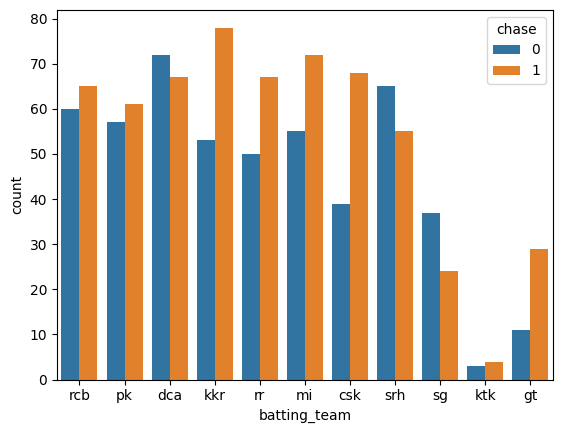

In [38]:
# Chase counts and success counts by team


sns.countplot(data=mdf, x='batting_team', hue='chase')


<Axes: xlabel='batting_team', ylabel='wickets_down'>

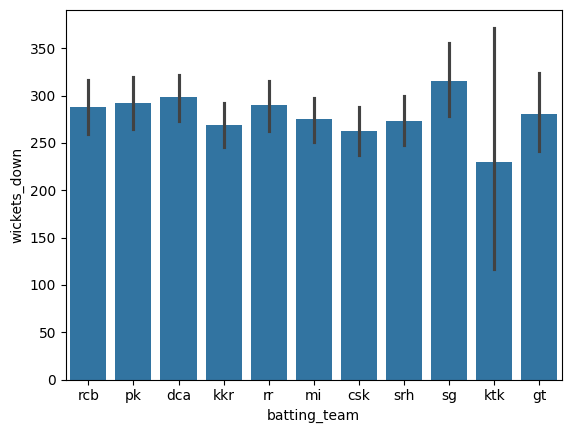

In [39]:
# Wickets dismissed per team in second innings.
sns.barplot(data=mdf, x='batting_team', y='wickets_down')


<Axes: xlabel='city'>

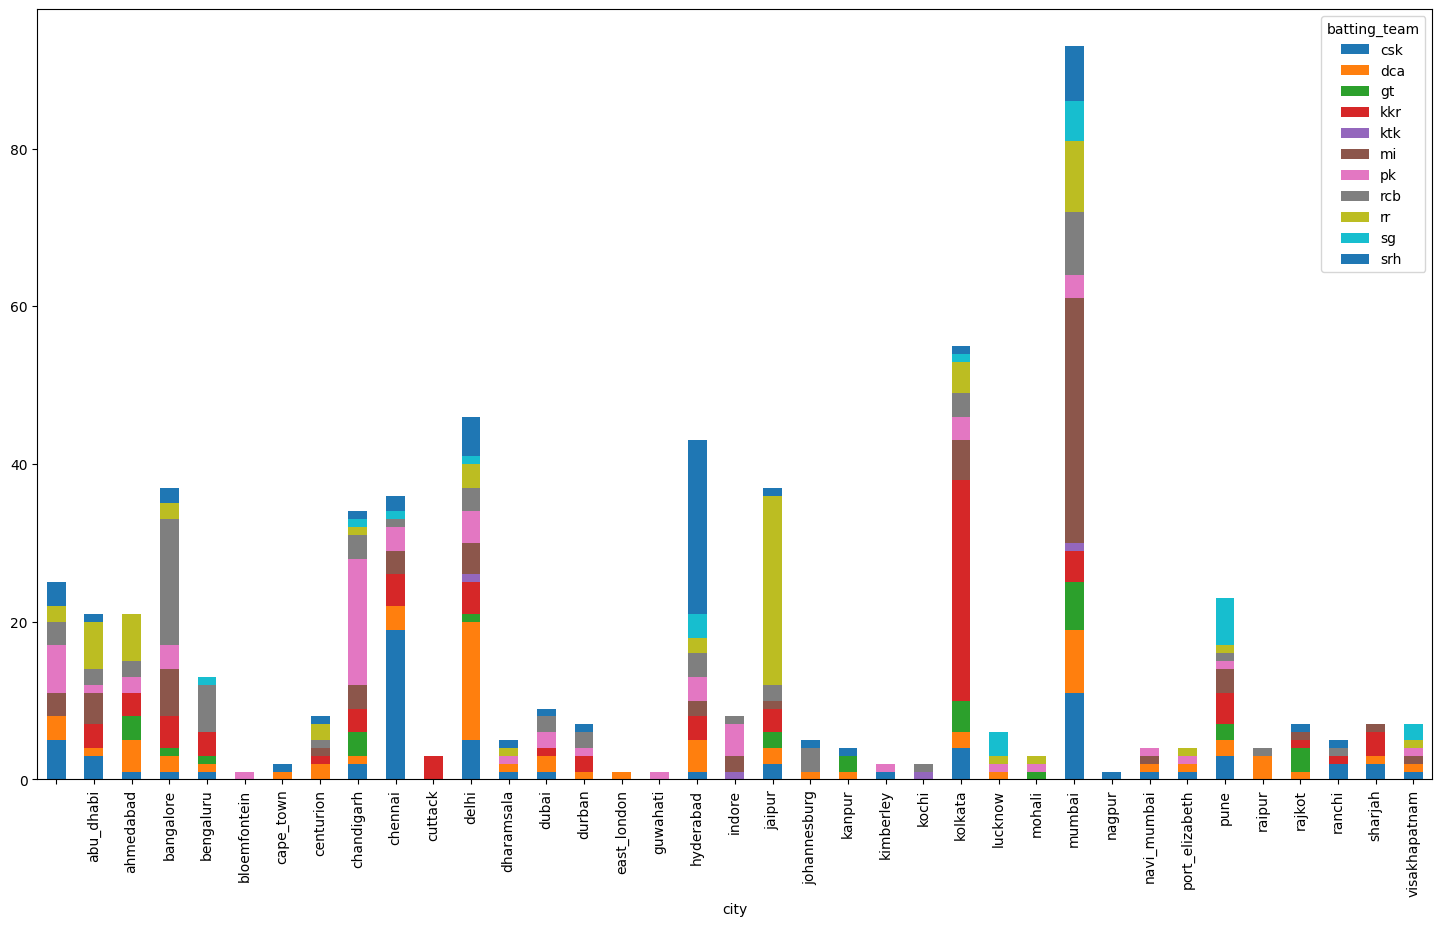

In [40]:
# Team wins over venue/city

city_win_counts = mdf.groupby(['city', 'batting_team'])['chase'].sum().reset_index(name='chased')
df_pivot = city_win_counts.pivot(index='city', columns='batting_team', values='chased').fillna(0)

# sns.barplot(data=city_win_counts, x='city', y='chased', hue='batting_team')
df_pivot.plot(kind='bar', stacked=True, figsize=(18, 10))

<Axes: xlabel='batting_team', ylabel='count'>

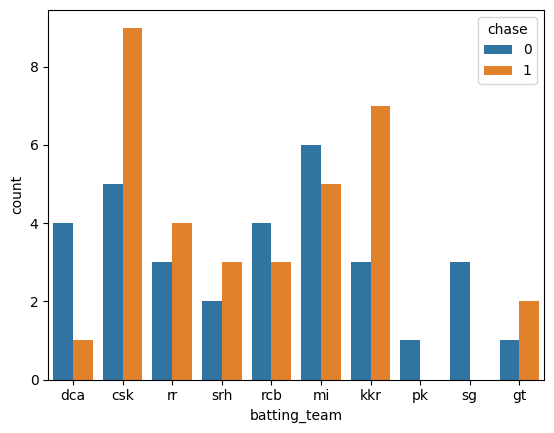

In [41]:
# Team presence in qualifiers
qdf = mdf[mdf.match_type != "league"].reset_index()
sns.countplot(data=qdf, x='batting_team', hue='chase')
   

In [42]:
# Toss win and decision stats

In [43]:
# Chasing team strike rate.

<Axes: >

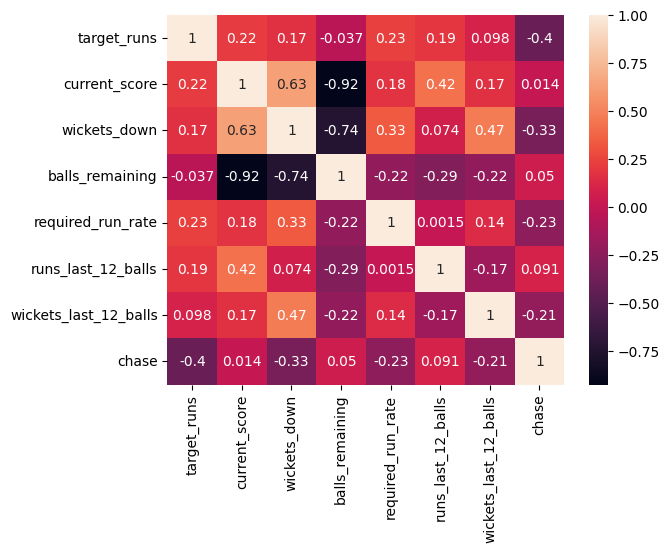

In [44]:
# Heatmap of similarity index of features.
my_cols = numeric_features + ['chase']
corr_mat = merged_df[my_cols].corr()

sns.heatmap(corr_mat, annot=True)

In [45]:
# Ensure the dataset is sorted by timeline.
main_df = merged_df.sort_values(by=['date', 'match_id', 'over', 'ball'])
main_df = main_df[cols_of_interest]

# Since it needs to be a time aware split, shuffle=False .. which results in past matches only for training and future matches for predictions.
df_full_train, df_test = train_test_split(main_df, test_size=.2, shuffle=False, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=.25, shuffle=False, random_state=1)
print(f"Length of df_train:{len(df_train)},  df_val:{len(df_val)},  df_test:{len(df_test)}")

y_train = df_train.pop('chase')
y_val = df_val.pop('chase')
y_test = df_test.pop('chase')
y_full_train = df_full_train.pop('chase')

Length of df_train:75108,  df_val:25036,  df_test:25037


In [46]:
df_test.season.min(), df_val.season.min(), df_train.season.min()


('2022', '2018', '2007/08')

In [47]:
df_test.season.max(), df_val.season.max(), df_train.season.max()


('2024', '2022', '2018')

In [48]:
df_train.head()

,season,match_type,batting_team,toss_winner,city,target_runs,current_score,wickets_down,balls_remaining,required_run_rate,runs_last_12_balls,wickets_last_12_balls
0,2007/08,league,rcb,rcb,bangalore,223.0,1,0,119.0,11.193277,NaN,NaN
1,2007/08,league,rcb,rcb,bangalore,223.0,2,0,118.0,11.237288,1.0,0.0
2,2007/08,league,rcb,rcb,bangalore,223.0,2,0,117.0,11.333333,2.0,0.0
3,2007/08,league,rcb,rcb,bangalore,223.0,3,0,116.0,11.379310,2.0,0.0
4,2007/08,league,rcb,rcb,bangalore,223.0,4,0,115.0,11.426087,3.0,0.0


In [49]:
# Target Encoding for High Cardinality Features
target_enc = ce.TargetEncoder(cols=high_cardinal_features)
df_train_encoded = target_enc.fit_transform(df_train, y_train)
df_val_encoded = target_enc.transform(df_val)

df_train = df_train_encoded.reset_index(drop=True)
df_val = df_val_encoded.reset_index(drop=True)


# Create Pipelines for Numerical and Categorical Features

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),    # Fill missing values with mean
    ('scaler', StandardScaler())                    # Standardize numerical values
])

# Categorical Transformer for One-Hot Encoding (for low cardinality categorical features)
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Column Transformer to apply transformations to different features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_features),
        ('cat', categorical_transformer, low_cardinal_features)
    ],
    remainder='drop'  # Drop any columns not specified
)

In [50]:
tscv = TimeSeriesSplit(n_splits=5)

for c in [0.01, .1, 1, 10, 100]:
    fold_aucs = []
    fold_accs = []
    i = 1
    for train_idx, val_idx in tscv.split(df_full_train):
        X_train_fold, X_val_fold = df_full_train.iloc[train_idx], df_full_train.iloc[val_idx]
        y_train_fold, y_val_fold = y_full_train.iloc[train_idx], y_full_train.iloc[val_idx]

        target_enc = ce.TargetEncoder(cols=high_cardinal_features, smoothing=10)
        # Transform with target encoding and preprocessor
        X_train_enc = target_enc.fit_transform(X_train_fold, y_train_fold)
        X_val_enc   = target_enc.transform(X_val_fold)
        
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', LogisticRegression(C=c, max_iter=1000, random_state=1, class_weight='balanced'))
        ])
        pipeline.fit(X_train_enc, y_train_fold)

        y_pred_fold_acc = pipeline.predict(X_val_enc)
        y_pred_fold = pipeline.predict_proba(X_val_enc)[:, 1]
        fold_accs.append(accuracy_score(y_val_fold, y_pred_fold_acc))
        fold_aucs.append(roc_auc_score(y_val_fold, y_pred_fold))
        #print(f"Split:{i} -> Accuracy={np.mean(fold_accs):.3f}, ROC AUC={np.mean(fold_aucs):.3f}")
        i += 1

    print(f"\nC={c}, Accuracy={np.mean(fold_accs):.4f}, ROC AUC={np.mean(fold_aucs):.4f}")



C=0.01, Accuracy=0.7641, ROC AUC=0.8520

C=0.1, Accuracy=0.7612, ROC AUC=0.8470

C=1, Accuracy=0.7584, ROC AUC=0.8432

C=10, Accuracy=0.7573, ROC AUC=0.8413

C=100, Accuracy=0.7550, ROC AUC=0.8391


In [51]:
fold_aucs = []
fold_accs = []
i = 1
for train_idx, val_idx in tscv.split(df_full_train):
    X_train, X_val = df_full_train.iloc[train_idx], df_full_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_full_train.iloc[train_idx], y_full_train.iloc[val_idx]

    # Transform with target encoding and preprocessor
    X_train_enc = target_enc.fit_transform(X_train, y_train_fold)
    X_val_enc   = target_enc.transform(X_val)
    
    rf_model = RandomForestClassifier(
        n_estimators=85,
        max_depth=5, 
        random_state=21,

)
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model',rf_model)
    ])
    pipeline.fit(X_train_enc, y_train_fold)

    y_pred_fold_acc = pipeline.predict(X_val_enc)
    y_pred_fold = pipeline.predict_proba(X_val_enc)[:, 1]
    fold_accs.append(accuracy_score(y_val_fold, y_pred_fold_acc))
    fold_aucs.append(roc_auc_score(y_val_fold, y_pred_fold))
    # print(f"{i} -> Depth=5, Accuracy={np.mean(fold_accs):.3f}, ROC AUC={np.mean(fold_aucs):.3f}")
    i += 1


print(f"Depth=5, Accuracy={np.mean(fold_accs):.3f}, ROC AUC={np.mean(fold_aucs):.3f}")


Depth=5, Accuracy=0.740, ROC AUC=0.829


In [52]:
importances = rf_model.feature_importances_

# Loop over each feature and its importance
for i in range(X_train.shape[1]):
    print(f"{(i+1):2d}: {df_full_train.columns[i]:30s} {importances[i]:.5f}")

 1: season                         0.20841
 2: match_type                     0.02217
 3: batting_team                   0.15376
 4: toss_winner                    0.01510
 5: city                           0.45767
 6: target_runs                    0.01398
 7: current_score                  0.04499
 8: wickets_down                   0.00081
 9: balls_remaining                0.00082
10: required_run_rate              0.00217
11: runs_last_12_balls             0.00073
12: wickets_last_12_balls          0.00060


In [53]:
#

In [54]:
scores = []
for n in range(20, 201, 20):

    rf_model = RandomForestClassifier(
        n_estimators=n,
        random_state=21,
    )
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model',rf_model)
    ])
    pipeline.fit(X_train_enc, y_train_fold)

    y_pred_fold = pipeline.predict_proba(X_val_enc)[:, 1]
    score = roc_auc_score(y_val_fold, y_pred_fold)

    scores.append((n, score))

In [55]:
scores

[(20, 0.8550710023285603),
 (40, 0.8611583701449032),
 (60, 0.8610269400061233),
 (80, 0.8629470395994616),
 (100, 0.8640591396569324),
 (120, 0.864331233800083),
 (140, 0.864495134914326),
 (160, 0.8638937866770302),
 (180, 0.8636957957571143),
 (200, 0.8639320796337859)]

In [56]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
df_scores

,n_estimators,auc
0,20,0.855071
1,40,0.861158
2,60,0.861027
3,80,0.862947
4,100,0.864059
5,120,0.864331
6,140,0.864495
7,160,0.863894
8,180,0.863696
9,200,0.863932


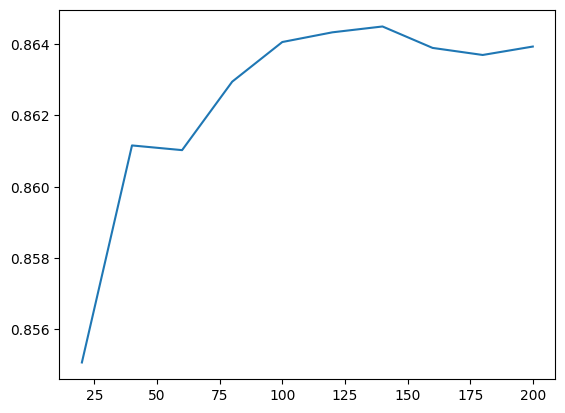

In [57]:
plt.plot(df_scores.n_estimators, df_scores.auc)

In [58]:
n = 80

In [59]:
scores = []
for d in [5, 10, 15]:
    for n in range(10, 201, 20):

        rf_model = RandomForestClassifier(
            n_estimators=n,
            max_depth=d,
            random_state=21,
        )
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model',rf_model)
        ])
        pipeline.fit(X_train_enc, y_train_fold)

        y_pred_fold = pipeline.predict_proba(X_val_enc)[:, 1]
        score = roc_auc_score(y_val_fold, y_pred_fold)

        scores.append((n, d, score))

In [60]:
columns = ['n_estimators', 'max_depth', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,n_estimators,max_depth,auc
0,10,5,0.843420
1,30,5,0.846192
2,50,5,0.851662
3,70,5,0.854046
4,90,5,0.853952


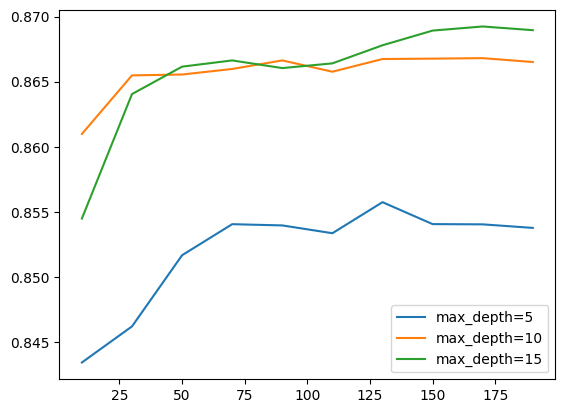

In [61]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label=f'max_depth={d}')

plt.legend()

In [62]:
d = 10

In [63]:
scores = []

for s in [3, 5, 10, 25]:
    for n in range(20, 201, 20):
            rf_model = RandomForestClassifier(
                n_estimators=n,
                max_depth=d,
                min_samples_leaf=s,
                random_state=21,
            )
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('model',rf_model)
            ])
            pipeline.fit(X_train_enc, y_train_fold)

            y_pred_fold = pipeline.predict_proba(X_val_enc)[:, 1]
            score = roc_auc_score(y_val_fold, y_pred_fold)

            scores.append((n, s, score))

In [64]:
columns = ['n_estimators', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,n_estimators,min_samples_leaf,auc
0,20,3,0.863286
1,40,3,0.863773
2,60,3,0.867198
3,80,3,0.866769
4,100,3,0.865976


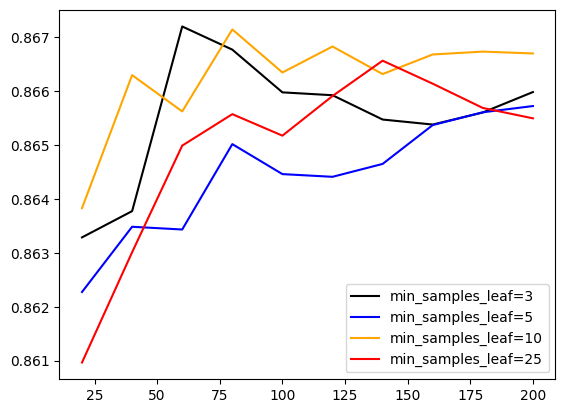

In [65]:
colors = ['black', 'blue', 'orange', 'red', 'gray']
min_samples_leaf_values = [3, 5, 10, 25]
samples_itr = list(zip(min_samples_leaf_values, colors))

for s, color in samples_itr:
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.auc, label=f'min_samples_leaf={s}', color=color)

plt.legend()

In [66]:
min_sample_leaves = 10

In [67]:
fold_aucs = []
fold_accs = []
for train_idx, val_idx in tscv.split(df_full_train):
    X_train, X_val = df_full_train.iloc[train_idx], df_full_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_full_train.iloc[train_idx], y_full_train.iloc[val_idx]

    # Transform with target encoding and preprocessor
    X_train_enc = target_enc.fit_transform(X_train, y_train_fold)
    X_val_enc   = target_enc.transform(X_val)
    
    rf_model = RandomForestClassifier(
        n_estimators=85,
        max_depth=15, 
        min_samples_leaf=10,
        random_state=21,

)
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model',rf_model)
    ])
    pipeline.fit(X_train_enc, y_train_fold)

    y_pred_fold_acc = pipeline.predict(X_val_enc)
    y_pred_fold = pipeline.predict_proba(X_val_enc)[:, 1]
    fold_accs.append(accuracy_score(y_val_fold, y_pred_fold_acc))
    fold_aucs.append(roc_auc_score(y_val_fold, y_pred_fold))


print(f"Accuracy={np.mean(fold_accs):.3f}, ROC AUC={np.mean(fold_aucs):.3f}")

Accuracy=0.753, ROC AUC=0.839


In [68]:
# Trying XGB

In [69]:
fold_aucs = []
fold_accs = []
for ne in [20, 25, 50, 75, 100, 125, 200]:
    for lr in [.01, .03, .05, .1]:
        model = XGBClassifier(
            n_estimators=ne,
            learning_rate=lr,
            # max_depth=md,
            # subsample=subs,
            # colsample_bytree=cs,
            random_state=21,
            eval_metric='auc'
        )

        fold_aucs = []
        fold_accs = []
        for train_idx, val_idx in tscv.split(df_full_train):
            X_train, X_val = df_full_train.iloc[train_idx], df_full_train.iloc[val_idx]
            y_train_fold, y_val_fold = y_full_train.iloc[train_idx], y_full_train.iloc[val_idx]

            # Transform with target encoding and preprocessor
            X_train_enc = target_enc.fit_transform(X_train, y_train_fold)
            X_val_enc   = target_enc.transform(X_val)
            
            pipeline = Pipeline([
                ('preprocessor', preprocessor),  
                ('model', model),
            ])
            pipeline.fit(X_train_enc, y_train_fold)

            y_pred_fold_acc = pipeline.predict(X_val_enc)
            y_pred_fold = pipeline.predict_proba(X_val_enc)[:, 1]

            fold_accs.append(accuracy_score(y_val_fold, y_pred_fold_acc))
            fold_aucs.append(roc_auc_score(y_val_fold, y_pred_fold))

        print(f"NE={ne}|LR={lr}| Accuracy={np.mean(fold_accs):.3f}, ROC AUC={np.mean(fold_aucs):.3f}")
    print("-" * 25)

NE=20|LR=0.01| Accuracy=0.746, ROC AUC=0.834
NE=20|LR=0.03| Accuracy=0.753, ROC AUC=0.843
NE=20|LR=0.05| Accuracy=0.751, ROC AUC=0.845
NE=20|LR=0.1| Accuracy=0.757, ROC AUC=0.848
-------------------------
NE=25|LR=0.01| Accuracy=0.749, ROC AUC=0.836
NE=25|LR=0.03| Accuracy=0.755, ROC AUC=0.844
NE=25|LR=0.05| Accuracy=0.751, ROC AUC=0.846
NE=25|LR=0.1| Accuracy=0.754, ROC AUC=0.849
-------------------------
NE=50|LR=0.01| Accuracy=0.749, ROC AUC=0.842
NE=50|LR=0.03| Accuracy=0.754, ROC AUC=0.847
NE=50|LR=0.05| Accuracy=0.753, ROC AUC=0.847
NE=50|LR=0.1| Accuracy=0.753, ROC AUC=0.844
-------------------------
NE=75|LR=0.01| Accuracy=0.754, ROC AUC=0.845
NE=75|LR=0.03| Accuracy=0.754, ROC AUC=0.847
NE=75|LR=0.05| Accuracy=0.754, ROC AUC=0.846
NE=75|LR=0.1| Accuracy=0.746, ROC AUC=0.838
-------------------------
NE=100|LR=0.01| Accuracy=0.754, ROC AUC=0.847
NE=100|LR=0.03| Accuracy=0.755, ROC AUC=0.849
NE=100|LR=0.05| Accuracy=0.750, ROC AUC=0.843
NE=100|LR=0.1| Accuracy=0.742, ROC AUC=0.8

In [70]:
# for ne in [50, 75, 100]:
#     for lr in [0.03]:
#         for md in [3, 5]:
#             model = XGBClassifier(
#                 n_estimators=ne,
#                 learning_rate=lr,
#                 max_depth=md,
#                 subsample=.7,
#                 colsample_bytree=.7,
#                 random_state=42,
#                 eval_metric='logloss'
#             )

#             fold_aucs = []
#             fold_accs = []
#             for train_idx, val_idx in tscv.split(df_full_train):
#                 X_train, X_val = df_full_train.iloc[train_idx], df_full_train.iloc[val_idx]
#                 y_train_fold, y_val_fold = y_full_train.iloc[train_idx], y_full_train.iloc[val_idx]

#                 # Transform with target encoding and preprocessor
#                 X_train_enc = target_enc.fit_transform(X_train, y_train_fold)
#                 X_val_enc   = target_enc.transform(X_val)
                
#                 pipeline = Pipeline([
#                     ('preprocessor', preprocessor),  
#                     ('model', model),
#                 ])
#                 pipeline.fit(X_train_enc, y_train_fold)

#                 y_pred_fold_acc = pipeline.predict(X_val_enc)
#                 y_pred_fold = pipeline.predict_proba(X_val_enc)[:, 1]

#                 fold_accs.append(accuracy_score(y_val_fold, y_pred_fold_acc))
#                 fold_aucs.append(roc_auc_score(y_val_fold, y_pred_fold))

#             print(f"NEst={ne}|LearnRate={lr}|Depth={md} Accuracy={np.mean(fold_accs):.3f}, ROC AUC={np.mean(fold_aucs):.3f}")
#         print()
#     print("+" * 25)

In [71]:
for ne in [100, 300, 500]:
    for lr in [0.01, 0.03]:
        for md in [3, 5, 7]:
            model = XGBClassifier(
                n_estimators=ne,
                learning_rate=lr,
                max_depth=md,
                subsample=.7,
                colsample_bytree=.7,
                random_state=21,
                eval_metric='logloss'
            )

            fold_aucs = []
            fold_accs = []
            for train_idx, val_idx in tscv.split(df_full_train):
                X_train, X_val = df_full_train.iloc[train_idx], df_full_train.iloc[val_idx]
                y_train_fold, y_val_fold = y_full_train.iloc[train_idx], y_full_train.iloc[val_idx]

                # Transform with target encoding and preprocessor
                X_train_enc = target_enc.fit_transform(X_train, y_train_fold)
                X_val_enc   = target_enc.transform(X_val)
                
                pipeline = Pipeline([
                    ('preprocessor', preprocessor),  
                    ('model', model),
                ])
                pipeline.fit(X_train_enc, y_train_fold)

                y_pred_fold_acc = pipeline.predict(X_val_enc)
                y_pred_fold = pipeline.predict_proba(X_val_enc)[:, 1]

                fold_accs.append(accuracy_score(y_val_fold, y_pred_fold_acc))
                fold_aucs.append(roc_auc_score(y_val_fold, y_pred_fold))

            print(f"NEst={ne}|LearnRate={lr}|Depth={md} Accuracy={np.mean(fold_accs):.3f}, ROC AUC={np.mean(fold_aucs):.3f}")
        print()
    print("+" * 25)

NEst=100|LearnRate=0.01|Depth=3 Accuracy=0.750, ROC AUC=0.845
NEst=100|LearnRate=0.01|Depth=5 Accuracy=0.754, ROC AUC=0.851
NEst=100|LearnRate=0.01|Depth=7 Accuracy=0.759, ROC AUC=0.851

NEst=100|LearnRate=0.03|Depth=3 Accuracy=0.756, ROC AUC=0.856
NEst=100|LearnRate=0.03|Depth=5 Accuracy=0.761, ROC AUC=0.855
NEst=100|LearnRate=0.03|Depth=7 Accuracy=0.755, ROC AUC=0.847

+++++++++++++++++++++++++
NEst=300|LearnRate=0.01|Depth=3 Accuracy=0.755, ROC AUC=0.856
NEst=300|LearnRate=0.01|Depth=5 Accuracy=0.759, ROC AUC=0.855
NEst=300|LearnRate=0.01|Depth=7 Accuracy=0.755, ROC AUC=0.849

NEst=300|LearnRate=0.03|Depth=3 Accuracy=0.764, ROC AUC=0.856
NEst=300|LearnRate=0.03|Depth=5 Accuracy=0.755, ROC AUC=0.844
NEst=300|LearnRate=0.03|Depth=7 Accuracy=0.748, ROC AUC=0.836

+++++++++++++++++++++++++
NEst=500|LearnRate=0.01|Depth=3 Accuracy=0.760, ROC AUC=0.858
NEst=500|LearnRate=0.01|Depth=5 Accuracy=0.760, ROC AUC=0.852
NEst=500|LearnRate=0.01|Depth=7 Accuracy=0.753, ROC AUC=0.844

NEst=500|Lear

In [72]:
# for ne in [100, 500]:
#     for g in [0.1, 0.3, 0.7]:
#         for ml in [1, 3, 5, 7]:
#             model = XGBClassifier(
#                 n_estimators=ne,
#                 learning_rate=0.01,
#                 max_depth=3,
#                 gamma=g,
#                 max_leaves=ml,
#                 subsample=.7,
#                 colsample_bytree=.7,
#                 random_state=21,
#                 eval_metric='logloss'
#             )

#             fold_aucs = []
#             fold_accs = []
#             for train_idx, val_idx in tscv.split(df_full_train):
#                 X_train, X_val = df_full_train.iloc[train_idx], df_full_train.iloc[val_idx]
#                 y_train_fold, y_val_fold = y_full_train.iloc[train_idx], y_full_train.iloc[val_idx]

#                 # Transform with target encoding and preprocessor
#                 X_train_enc = target_enc.fit_transform(X_train, y_train_fold)
#                 X_val_enc   = target_enc.transform(X_val)
                
#                 pipeline = Pipeline([
#                     ('preprocessor', preprocessor),  
#                     ('model', model),
#                 ])
#                 pipeline.fit(X_train_enc, y_train_fold)

#                 y_pred_fold_acc = pipeline.predict(X_val_enc)
#                 y_pred_fold = pipeline.predict_proba(X_val_enc)[:, 1]

#                 fold_accs.append(accuracy_score(y_val_fold, y_pred_fold_acc))
#                 fold_aucs.append(roc_auc_score(y_val_fold, y_pred_fold))

#             print(f"NEst={ne}|Gamma={g}|MinLeaves={ml} Accuracy={np.mean(fold_accs):.3f}, ROC AUC={np.mean(fold_aucs):.3f}")
#         print()
#     print("+" * 25)

In [73]:
# help(XGBClassifier)

In [74]:
# NEst=500|Gamma=0.7|MinLeaves=5 Accuracy=0.744, ROC AUC=0.854


In [75]:
model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.01,
    max_depth=3,
    max_leaves=5,
    subsample=.7,
    colsample_bytree=.7,
    random_state=21,
    eval_metric='logloss'
)

fold_aucs = []
fold_accs = []
for train_idx, val_idx in tscv.split(df_full_train):
    X_train, X_val = df_full_train.iloc[train_idx], df_full_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_full_train.iloc[train_idx], y_full_train.iloc[val_idx]

    # Transform with target encoding and preprocessor
    X_train_enc = target_enc.fit_transform(X_train, y_train_fold)
    X_val_enc   = target_enc.transform(X_val)
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  
        ('model', model),
    ])
    pipeline.fit(X_train_enc, y_train_fold)

    y_pred_fold_acc = pipeline.predict(X_val_enc)
    y_pred_fold = pipeline.predict_proba(X_val_enc)[:, 1]

    fold_accs.append(accuracy_score(y_val_fold, y_pred_fold_acc))
    fold_aucs.append(roc_auc_score(y_val_fold, y_pred_fold))

print(f" Accuracy={np.mean(fold_accs):.3f}, ROC AUC={np.mean(fold_aucs):.3f}")


 Accuracy=0.758, ROC AUC=0.858


In [76]:
# Test with XGB
X_test   = target_enc.transform(df_test)

y_pred_acc = pipeline.predict(X_test)
y_pred = pipeline.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred_acc)
auc = roc_auc_score(y_test, y_pred)
print(f"Final Accuracy={acc:.3f}, ROC AUC={auc:.3f}")

Final Accuracy=0.790, ROC AUC=0.869


In [77]:
## Check with LR again

In [78]:
tscv = TimeSeriesSplit(n_splits=5)
for itr in [100, 500, 1000, 2000]:
    for c in [0.005, 0.01, 0.03]:
        fold_aucs = []
        fold_accs = []
        i = 1
        for train_idx, val_idx in tscv.split(df_full_train):
            X_train_fold, X_val_fold = df_full_train.iloc[train_idx], df_full_train.iloc[val_idx]
            y_train_fold, y_val_fold = y_full_train.iloc[train_idx], y_full_train.iloc[val_idx]

            target_enc = ce.TargetEncoder(cols=high_cardinal_features, smoothing=10)
            # Transform with target encoding and preprocessor
            X_train_enc = target_enc.fit_transform(X_train_fold, y_train_fold)
            X_val_enc   = target_enc.transform(X_val_fold)
            
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('model', LogisticRegression(C=c, max_iter=itr, random_state=21, class_weight='balanced'))
            ])
            pipeline.fit(X_train_enc, y_train_fold)

            y_pred_fold_acc = pipeline.predict(X_val_enc)
            y_pred_fold = pipeline.predict_proba(X_val_enc)[:, 1]
            fold_accs.append(accuracy_score(y_val_fold, y_pred_fold_acc))
            fold_aucs.append(roc_auc_score(y_val_fold, y_pred_fold))
            #print(f"Split:{i} -> Accuracy={np.mean(fold_accs):.3f}, ROC AUC={np.mean(fold_aucs):.3f}")
            i += 1

        print(f"I={itr}|C={c}, Accuracy={np.mean(fold_accs):.4f}, ROC AUC={np.mean(fold_aucs):.4f}")
    print()

I=100|C=0.005, Accuracy=0.7640, ROC AUC=0.8524
I=100|C=0.01, Accuracy=0.7641, ROC AUC=0.8520
I=100|C=0.03, Accuracy=0.7627, ROC AUC=0.8497

I=500|C=0.005, Accuracy=0.7640, ROC AUC=0.8524
I=500|C=0.01, Accuracy=0.7641, ROC AUC=0.8520
I=500|C=0.03, Accuracy=0.7627, ROC AUC=0.8497

I=1000|C=0.005, Accuracy=0.7640, ROC AUC=0.8524
I=1000|C=0.01, Accuracy=0.7641, ROC AUC=0.8520
I=1000|C=0.03, Accuracy=0.7627, ROC AUC=0.8497

I=2000|C=0.005, Accuracy=0.7640, ROC AUC=0.8524
I=2000|C=0.01, Accuracy=0.7641, ROC AUC=0.8520
I=2000|C=0.03, Accuracy=0.7627, ROC AUC=0.8497



In [79]:
tscv = TimeSeriesSplit(n_splits=5)

fold_aucs = []
fold_accs = []
i = 1
for train_idx, val_idx in tscv.split(df_full_train):
    X_train_fold, X_val_fold = df_full_train.iloc[train_idx], df_full_train.iloc[val_idx]
    y_train_fold, y_val_fold = y_full_train.iloc[train_idx], y_full_train.iloc[val_idx]

    target_enc = ce.TargetEncoder(cols=high_cardinal_features, smoothing=10)
    # Transform with target encoding and preprocessor
    X_train_enc = target_enc.fit_transform(X_train_fold, y_train_fold)
    X_val_enc   = target_enc.transform(X_val_fold)
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', LogisticRegression(C=0.01, max_iter=1000, random_state=21, class_weight='balanced'))
    ])
    pipeline.fit(X_train_enc, y_train_fold)

    y_pred_fold_acc = pipeline.predict(X_val_enc)
    y_pred_fold = pipeline.predict_proba(X_val_enc)[:, 1]
    fold_accs.append(accuracy_score(y_val_fold, y_pred_fold_acc))
    fold_aucs.append(roc_auc_score(y_val_fold, y_pred_fold))
    #print(f"Split:{i} -> Accuracy={np.mean(fold_accs):.3f}, ROC AUC={np.mean(fold_aucs):.3f}")
    i += 1

print(f" Accuracy={np.mean(fold_accs):.4f}, ROC AUC={np.mean(fold_aucs):.4f}")

 Accuracy=0.7641, ROC AUC=0.8520


In [80]:
# Test with LR
X_test   = target_enc.transform(df_test)

y_pred_acc = pipeline.predict(X_test)
y_pred = pipeline.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred_acc)
auc = roc_auc_score(y_test, y_pred)
print(f"Final Accuracy={acc:.3f}, ROC AUC={auc:.3f}")

Final Accuracy=0.796, ROC AUC=0.875


In [81]:
## => Logistic Regression almost fares well as XGB . Considering LR as final model 

In [82]:
import json
match_state_input = df_test.iloc[20].to_dict()
match_state_input

{'season': '2022',
 'match_type': 'league',
 'batting_team': 'gt',
 'toss_winner': 'gt',
 'city': 'mumbai',
 'target_runs': 159.0,
 'current_score': 39,
 'wickets_down': 2,
 'balls_remaining': 94.0,
 'required_run_rate': 7.659574468085107,
 'runs_last_12_balls': 24.0,
 'wickets_last_12_balls': 0.0}

In [89]:
def predict(input: dict):

    df_test = pd.DataFrame([input])  
    X   = target_enc.transform(df_test)
    #X = preprocessor.transform(X_enc)

    y_pred = pipeline.predict_proba(X)[:, 1][0]

    print(f"Predicted Win: {y_pred * 100:.2f}% for chasing team '{str(input['batting_team']).upper()}' ")
    

In [90]:
predict(match_state_input)

Predicted Win: 74.03% for chasing team 'GT' 


In [91]:
test1 = {
 'season': '2022',
 'match_type': 'league',
 'batting_team': 'rcb',
 'toss_winner': 'mi',
 'city': 'mumbai',
 'target_runs': 159.0,
 'current_score': 39,
 'wickets_down': 3,
 'balls_remaining': 94.0,
 'required_run_rate': 159/94 * 6,
 'runs_last_12_balls': 24.0,
 'wickets_last_12_balls': 0.0
}
predict(test1)

Predicted Win: 38.03% for chasing team 'RCB' 
